In [0]:
# Load table as a PySpark DataFrame
df = spark.table("default.retail_data")  # use schema.table_name

df.show(5)

+--------------------+--------------------+--------------------+-----------+------+--------+-----------+--------------+-------------------+-------------+
|      transaction_id|             user_id|          product_id|   category| price|discount|final_price|payment_method|      purchase_date|       region|
+--------------------+--------------------+--------------------+-----------+------+--------+-----------+--------------+-------------------+-------------+
|258890ef-014d-44d...|bdd640fb-0667-4ad...|23b8c1e9-3924-46d...|       Home|643.03|    0.01|      636.6|        Wallet|2025-01-13 13:18:16|       Europe|
|7a26c716-b794-416...|e465e150-bd9c-46b...|6c031199-972a-446...|      Books|148.14|    0.05|     140.73|          Card|2023-07-16 04:57:29|       Africa|
|4d1e8fee-4c10-4f3...|3b8faa18-37f8-488...|8fadc1a6-06cb-4fb...|   Clothing| 427.7|    0.01|     423.42|        Wallet|2023-11-22 23:05:18|       Africa|
|42c52730-01b7-40c...|8b8148f6-b38a-488...|96da1dac-72ff-4d2...|      Books|

In [0]:
# Import Required Libraries
from pyspark.sql.functions import col, countDistinct, isnan, when, count, mean, stddev, min, max
from pyspark.sql.functions import to_date, date_format
from pyspark.sql.functions import year, month, dayofmonth, dayofweek, hour

import matplotlib.pyplot as plt

In [0]:
# DataFrame Overview
df.printSchema()
df.show(5)
df.count()  # Total rows
len(df.columns)  # Total columns

root
 |-- transaction_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category: string (nullable = true)
 |-- price: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- final_price: double (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- purchase_date: timestamp (nullable = true)
 |-- region: string (nullable = true)

+--------------------+--------------------+--------------------+-----------+------+--------+-----------+--------------+-------------------+-------------+
|      transaction_id|             user_id|          product_id|   category| price|discount|final_price|payment_method|      purchase_date|       region|
+--------------------+--------------------+--------------------+-----------+------+--------+-----------+--------------+-------------------+-------------+
|258890ef-014d-44d...|bdd640fb-0667-4ad...|23b8c1e9-3924-46d...|       Home|643.03|    0.01|      636.6|        W

10

In [0]:
# Null Value Check (Critical for Profiling)
null_counts = []
for c in df.columns:
    dtype = dict(df.dtypes)[c]
    if dtype in ['double', 'float']:
        null_counts.append(count(when(isnan(col(c)) | col(c).isNull(), c)).alias(c))
    else:
        null_counts.append(count(when(col(c).isNull(), c)).alias(c))

df.select(null_counts).show()

+--------------+-------+----------+--------+-----+--------+-----------+--------------+-------------+------+
|transaction_id|user_id|product_id|category|price|discount|final_price|payment_method|purchase_date|region|
+--------------+-------+----------+--------+-----+--------+-----------+--------------+-------------+------+
|             0|      0|         0|       0|    0|       0|          0|             0|            0|     0|
+--------------+-------+----------+--------+-----+--------+-----------+--------------+-------------+------+



In [0]:
# Summary Statistics for Numerical Columns
df.describe().show()

+-------+--------------------+--------------------+--------------------+--------+------------------+-------------------+------------------+--------------+-------------+
|summary|      transaction_id|             user_id|          product_id|category|             price|           discount|       final_price|payment_method|       region|
+-------+--------------------+--------------------+--------------------+--------+------------------+-------------------+------------------+--------------+-------------+
|  count|              100000|              100000|              100000|  100000|            100000|             100000|            100000|        100000|       100000|
|   mean|                NULL|                NULL|                NULL|    NULL|505.25778160000215|0.25047449999999954|378.84063750000695|          NULL|         NULL|
| stddev|                NULL|                NULL|                NULL|    NULL| 285.1526606230797|0.14434794841996257|229.59188594009032|          NULL| 

In [0]:
# Cardinality of Categorical Columns
cat_cols = [c for (c, dtype) in df.dtypes if dtype == 'string']
df.select([countDistinct(col(c)).alias(f"{c}_nunique") for c in cat_cols]).show()

+----------------------+---------------+------------------+----------------+----------------------+--------------+
|transaction_id_nunique|user_id_nunique|product_id_nunique|category_nunique|payment_method_nunique|region_nunique|
+----------------------+---------------+------------------+----------------+----------------------+--------------+
|                100000|         100000|            100000|               6|                     4|             5|
+----------------------+---------------+------------------+----------------+----------------------+--------------+



In [0]:
# Bronze Layer: Load Raw Data
# Save to Unity Catalog as a managed table
spark.sql("CREATE DATABASE IF NOT EXISTS retail_pipeline")

df.write.format("delta").mode("overwrite").saveAsTable("retail_pipeline.retail_bronze")

### Distribution Insights 

In [0]:
#Top Selling Products

df.groupBy("product_id").count().orderBy("count", ascending=False).show(10)

+--------------------+-----+
|          product_id|count|
+--------------------+-----+
|bf64f03d-e974-4e3...|    1|
|9a3336ee-3938-432...|    1|
|6c99ce56-a58a-4bb...|    1|
|5953b5d4-2e85-460...|    1|
|4d2a5ec7-029d-44a...|    1|
|75ef8169-64a7-427...|    1|
|7c928924-ff2c-4e6...|    1|
|2a23e15b-82b1-44b...|    1|
|ef46e612-6d5c-484...|    1|
|9d7c24ce-85d5-4ed...|    1|
+--------------------+-----+
only showing top 10 rows


In [0]:
# Distribution of Discount Rates

df.groupBy("discount").count().orderBy("discount").show()

+--------+-----+
|discount|count|
+--------+-----+
|     0.0|  982|
|    0.01| 1958|
|    0.02| 2011|
|    0.03| 2003|
|    0.04| 2002|
|    0.05| 1990|
|    0.06| 1915|
|    0.07| 2072|
|    0.08| 2010|
|    0.09| 2081|
|     0.1| 1923|
|    0.11| 1932|
|    0.12| 2062|
|    0.13| 2038|
|    0.14| 2016|
|    0.15| 2006|
|    0.16| 1911|
|    0.17| 1954|
|    0.18| 2014|
|    0.19| 2004|
+--------+-----+
only showing top 20 rows


In [0]:
# Sales by Payment Method

df.groupBy("payment_method").count().orderBy("count", ascending=False).show()

+--------------+-----+
|payment_method|count|
+--------------+-----+
|          Card|25161|
|           COD|25103|
|        Wallet|24925|
|           UPI|24811|
+--------------+-----+



In [0]:
# Sales by Product Category

df.groupBy("category").count().orderBy("count", ascending=False).show()

+-----------+-----+
|   category|count|
+-----------+-----+
|       Home|16743|
|Electronics|16698|
|     Beauty|16661|
|      Books|16642|
|   Clothing|16632|
|       Toys|16624|
+-----------+-----+



In [0]:
# Monthly Transaction Volume

df.groupBy(month("purchase_date").alias("month")).count().orderBy("month").show()

+-----+-----+
|month|count|
+-----+-----+
|    1| 8484|
|    2| 7820|
|    3| 8430|
|    4| 8307|
|    5| 8324|
|    6| 8011|
|    7| 8635|
|    8| 8469|
|    9| 8290|
|   10| 8605|
|   11| 8191|
|   12| 8434|
+-----+-----+



In [0]:
# Daily Transaction Volume

df.groupBy(dayofweek("purchase_date").alias("dayofweek")).count().orderBy("dayofweek").show()

+---------+-----+
|dayofweek|count|
+---------+-----+
|        1|14285|
|        2|14025|
|        3|14215|
|        4|14292|
|        5|14400|
|        6|14383|
|        7|14400|
+---------+-----+



In [0]:
# Users with the Most Transactions

df.groupBy("user_id").count().orderBy("count", ascending=False).show(10)

+--------------------+-----+
|             user_id|count|
+--------------------+-----+
|2d03fb11-ddc2-44e...|    1|
|30d569ed-4684-4c7...|    1|
|193e638d-774c-4af...|    1|
|19edcdbc-ec39-412...|    1|
|69331443-c92c-4f7...|    1|
|4f10b422-1fc2-451...|    1|
|29fd9415-8028-4f6...|    1|
|743b4f4f-2e8c-4b3...|    1|
|2ea816ef-6249-49a...|    1|
|c88994e7-49ef-408...|    1|
+--------------------+-----+
only showing top 10 rows


### Data Cleaning and Feature Engineering

In [0]:
# Handle Missing Values

missing_counts = df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df.columns
])
missing_counts.show()

+--------------+-------+----------+--------+-----+--------+-----------+--------------+-------------+------+
|transaction_id|user_id|product_id|category|price|discount|final_price|payment_method|purchase_date|region|
+--------------+-------+----------+--------+-----+--------+-----------+--------------+-------------+------+
|             0|      0|         0|       0|    0|       0|          0|             0|            0|     0|
+--------------+-------+----------+--------+-----+--------+-----------+--------------+-------------+------+



In [0]:
# Convert Data Types ensuring Purchase_Date is in proper date format:

df = df.withColumn("purchase_date", to_date(col("purchase_date"), "MM-dd-yyyy"))

df.select("purchase_date").show(5)

+-------------+
|purchase_date|
+-------------+
|   2025-01-13|
|   2023-07-16|
|   2023-11-22|
|   2024-01-23|
|   2024-03-11|
+-------------+
only showing top 5 rows


In [0]:
# Create Derived Features (Enrichment)

df = df.withColumn("Year", year("purchase_date")) \
       .withColumn("Month", month("purchase_date")) \
       .withColumn("Day", dayofmonth("purchase_date"))

df = df.withColumn("Discount_Amount", (col("price") * col("discount") / 100))

df = df.withColumn("Is_High_Discount", (col("discount") > 30).cast("int"))


In [0]:
df.printSchema()
df.show(5)

root
 |-- transaction_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category: string (nullable = true)
 |-- price: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- final_price: double (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- purchase_date: date (nullable = true)
 |-- region: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Discount_Amount: double (nullable = true)
 |-- Is_High_Discount: integer (nullable = true)

+--------------------+--------------------+--------------------+-----------+------+--------+-----------+--------------+-------------+-------------+----+-----+---+------------------+----------------+
|      transaction_id|             user_id|          product_id|   category| price|discount|final_price|payment_method|purchase_date|       region|Year|Month|Day|   Discount_

### Exploratory Data Analysis (EDA)

In [0]:
# Grab functions
from pyspark.sql import functions as F

In [0]:
# Overall Revenue Trends (by Year-Month)
monthly_revenue = (
    df.groupBy("year", "month")
      .agg(F.round(F.sum("final_price"), 2).alias("monthly_revenue"))
      .orderBy("year", "month")
)
monthly_revenue.show()

+----+-----+---------------+
|year|month|monthly_revenue|
+----+-----+---------------+
|2023|    6|      480340.54|
|2023|    7|     1600947.64|
|2023|    8|     1622559.62|
|2023|    9|      1524438.2|
|2023|   10|     1660197.75|
|2023|   11|     1539039.13|
|2023|   12|     1625710.26|
|2024|    1|      1602949.9|
|2024|    2|     1486739.63|
|2024|    3|     1609237.69|
|2024|    4|     1551700.36|
|2024|    5|      1582012.4|
|2024|    6|     1556425.37|
|2024|    7|     1682192.64|
|2024|    8|     1589168.78|
|2024|    9|     1582160.07|
|2024|   10|     1644831.74|
|2024|   11|     1554960.06|
|2024|   12|     1584165.89|
|2025|    1|     1635623.34|
+----+-----+---------------+
only showing top 20 rows


In [0]:
# Top-Selling Categories (Volume & Revenue)
category_perf = (
    df.groupBy("category")
      .agg(
          F.count("*").alias("total_transactions"),
          F.round(F.sum("final_price"), 2).alias("total_revenue")
      )
      .orderBy(F.desc("total_revenue"))
)
category_perf.show()

+-----------+------------------+-------------+
|   category|total_transactions|total_revenue|
+-----------+------------------+-------------+
|   Clothing|             16632|   6342671.95|
|       Home|             16743|   6332215.78|
|Electronics|             16698|   6326943.59|
|     Beauty|             16661|   6321260.49|
|       Toys|             16624|   6285589.32|
|      Books|             16642|   6275382.62|
+-----------+------------------+-------------+



In [0]:
# Payment-Method Preferences
payment_stats = (
    df.groupBy("payment_method")
      .agg(
          F.count("*").alias("Txn_Count"),
          F.round(F.avg("final_price"), 2).alias("Avg_Order_Value"),
          F.round(F.sum("final_price"), 2).alias("Total_Revenue")
      )
      .orderBy(F.desc("Txn_Count"))
)
payment_stats.show()

+--------------+---------+---------------+-------------+
|payment_method|Txn_Count|Avg_Order_Value|Total_Revenue|
+--------------+---------+---------------+-------------+
|          Card|    25161|         379.82|   9556737.41|
|           COD|    25103|         380.18|   9543604.53|
|        Wallet|    24925|         378.19|   9426279.01|
|           UPI|    24811|         377.15|    9357442.8|
+--------------+---------+---------------+-------------+



In [0]:
# Discount Impact

# a. Average Final Price vs Discount Bucket
df_bucketed = df.withColumn(
    "discount_bucket",
    F.when(F.col("discount") <= 10, "0-10%")
     .when(F.col("discount") <= 30, "11-30%")
     .otherwise("31-50%")
)

discount_imp = (
    df_bucketed.groupBy("discount_bucket")
               .agg(
                   F.round(F.avg("final_price"), 2).alias("Avg_Final_Price"),
                   F.count("*").alias("Txn_Count")
               )
               .orderBy("discount_bucket")
)
discount_imp.show()

# b. Correlation between Discount and Final Price
corr_val = df.stat.corr("discount", "final_price")
print(f"Correlation (Discount vs Final_Price): {corr_val:.3f}")

+---------------+---------------+---------+
|discount_bucket|Avg_Final_Price|Txn_Count|
+---------------+---------------+---------+
|          0-10%|         378.84|   100000|
+---------------+---------------+---------+

Correlation (Discount vs Final_Price): -0.319


In [0]:
# High-Value Customers (Top 10 by Lifetime Spend)
top_users = (
    df.groupBy("User_ID")
      .agg(F.round(F.sum("Final_Price"), 2).alias("Total_Spend"))
      .orderBy(F.desc("Total_Spend"))
      .limit(10)
)
top_users.show()

+--------------------+-----------+
|             User_ID|Total_Spend|
+--------------------+-----------+
|732fc932-ab96-469...|     998.02|
|27aa808a-9d72-47b...|     997.46|
|9af32699-cee6-4db...|     997.37|
|f82b85e2-78d1-47d...|     997.35|
|a2bf6aca-f10a-45a...|     995.46|
|30620786-2a91-441...|     995.13|
|bf6f8818-0dc9-43d...|     994.51|
|00e612c3-0e71-41a...|     992.77|
|a6fc359b-7782-493...|     991.91|
|1f47145c-2a51-415...|      991.1|
+--------------------+-----------+



In [0]:
# Daily Order Volume Heat-Map Table
daily_counts = (
    df.groupBy("Year", "Month", "Day")
      .agg(F.count("*").alias("Daily_Txns"))
      .orderBy("Year", "Month", "Day")
)
daily_counts.show()

+----+-----+---+----------+
|Year|Month|Day|Daily_Txns|
+----+-----+---+----------+
|2023|    6| 21|        62|
|2023|    6| 22|       124|
|2023|    6| 23|       137|
|2023|    6| 24|       148|
|2023|    6| 25|       125|
|2023|    6| 26|       139|
|2023|    6| 27|       132|
|2023|    6| 28|       109|
|2023|    6| 29|       142|
|2023|    6| 30|       131|
|2023|    7|  1|       154|
|2023|    7|  2|       129|
|2023|    7|  3|       139|
|2023|    7|  4|       131|
|2023|    7|  5|       147|
|2023|    7|  6|       141|
|2023|    7|  7|       133|
|2023|    7|  8|       137|
|2023|    7|  9|       123|
|2023|    7| 10|       120|
+----+-----+---+----------+
only showing top 20 rows


In [0]:
kpi = (
    df.agg(
        F.round(F.sum("Final_Price"), 2).alias("Total_Revenue"),
        F.count("*").alias("Total_Transactions"),
        F.round(F.avg("Final_Price"), 2).alias("Avg_Order_Value"),
        F.countDistinct("User_ID").alias("Unique_Customers"),
        F.round(F.avg("Discount"), 2).alias("Avg_Discount_%")
    )
)
kpi.show()

+-------------+------------------+---------------+----------------+--------------+
|Total_Revenue|Total_Transactions|Avg_Order_Value|Unique_Customers|Avg_Discount_%|
+-------------+------------------+---------------+----------------+--------------+
|3.788406375E7|            100000|         378.84|          100000|          0.25|
+-------------+------------------+---------------+----------------+--------------+



### Data Aggregation & Business KPI Derivation

In [0]:
from pyspark.sql.functions import col, to_timestamp, round as spark_round, when

retail_data_cleaned = df.withColumn(
    "purchase_date", to_timestamp("purchase_date", "dd-MM-yyyy")
).withColumn(
    "discount_amount", (col("price") * col("discount") / 100.0)
).withColumn(
    "high_discount_flag", when(col("discount") >= 30, 1).otherwise(0)
).select(
    "user_id", "product_id", "category", "price", "discount",
    "discount_amount", "final_price", "payment_method", "purchase_date", "high_discount_flag"
)

In [0]:
retail_data_cleaned.createOrReplaceTempView("retail_data_cleaned")

In [0]:
# Silver Layer: Cleaned Data (after feature engineering and filtering)
retail_data_cleaned.write.format("delta").mode("overwrite").saveAsTable("retail_pipeline.retail_silver")

In [0]:
# Calculate Total Sales, Discounts, and Units
query = """
SELECT
  ROUND(SUM(Final_Price), 2) AS Total_Revenue,
  ROUND(SUM(Discount_Amount), 2) AS Total_Discount_Given,
  COUNT(*) AS Total_Transactions
FROM retail_data_cleaned
"""

# Execute the query
result_df = spark.sql(query)

# Display the result
display(result_df)

Total_Revenue,Total_Discount_Given,Total_Transactions
3.788406375E7,126417.15,100000


In [0]:
# Monthly Revenue Trend
monthly_query = """
SELECT
  Year,
  Month,
  ROUND(SUM(Final_Price), 2) AS Monthly_Revenue
FROM retail_data_cleaned
GROUP BY Year, Month
ORDER BY Year, Month
"""

monthly_df = spark.sql(monthly_query)
display(monthly_df)

Year,Month,Monthly_Revenue
2023,6,480340.54
2023,7,1600947.64
2023,8,1622559.62
2023,9,1524438.2
2023,10,1660197.75
2023,11,1539039.13
2023,12,1625710.26
2024,1,1602949.9
2024,2,1486739.63
2024,3,1609237.69


In [0]:
# Revenue by Product Category
category_query = """
SELECT
  Category,
  ROUND(SUM(Final_Price), 2) AS Total_Revenue,
  COUNT(*) AS Number_of_Transactions
FROM retail_data_cleaned
GROUP BY Category
ORDER BY Total_Revenue DESC
"""

category_df = spark.sql(category_query)
display(category_df)

Category,Total_Revenue,Number_of_Transactions
Clothing,6342671.95,16632
Home,6332215.78,16743
Electronics,6326943.59,16698
Beauty,6321260.49,16661
Toys,6285589.32,16624
Books,6275382.62,16642


In [0]:
# Create a temporary view with Month and Year extracted
monthly_trend_df = retail_data_cleaned.withColumn("month", F.month("purchase_date")) \
                                    .withColumn("year", F.year("purchase_date"))
monthly_trend_df.createOrReplaceTempView("retail_data_monthly")

# SQL query for monthly revenue
monthly_query = """
SELECT
  Year,
  Month,
  ROUND(SUM(Final_Price), 2) AS Monthly_Revenue
FROM retail_data_monthly
GROUP BY Year, Month
ORDER BY Year, Month
"""

monthly_sales_df = spark.sql(monthly_query)
display(monthly_sales_df)

Year,Month,Monthly_Revenue
2023,6,480340.54
2023,7,1600947.64
2023,8,1622559.62
2023,9,1524438.2
2023,10,1660197.75
2023,11,1539039.13
2023,12,1625710.26
2024,1,1602949.9
2024,2,1486739.63
2024,3,1609237.69


-  Average Order Value (AOV): Total Revenue / Number of Transactions
-  Average Discount Rate: Total Discount Given / Total Revenue

In [0]:
# Average Order Value (AOV) and Discount Rate

query = """
SELECT
  ROUND(SUM(final_price), 2) AS Total_Revenue,
  COUNT(*) AS Total_Transactions,
  ROUND(SUM(final_price) / COUNT(*), 2) AS Average_Order_Value,
  ROUND(SUM(discount_amount) / SUM(final_price), 4) * 100 AS Average_Discount_Percentage
FROM retail_data_cleaned
"""

aov_df = spark.sql(query)
display(aov_df)

Total_Revenue,Total_Transactions,Average_Order_Value,Average_Discount_Percentage
3.788406375E7,100000,378.84,0.33


In [0]:
# Key Performance By Category
query = """
SELECT
  category,
  COUNT(*) AS Total_Transactions,
  ROUND(SUM(final_price), 2) AS Total_Revenue,
  ROUND(AVG(final_price), 2) AS Avg_Revenue_per_Transaction,
  ROUND(AVG(discount_amount), 2) AS Avg_Discount
FROM retail_data_cleaned
GROUP BY category
ORDER BY Total_Revenue DESC
"""

category_perf_df = spark.sql(query)
display(category_perf_df)

category,Total_Transactions,Total_Revenue,Avg_Revenue_per_Transaction,Avg_Discount
Clothing,16632,6342671.95,381.35,1.29
Home,16743,6332215.78,378.2,1.27
Electronics,16698,6326943.59,378.9,1.26
Beauty,16661,6321260.49,379.4,1.25
Toys,16624,6285589.32,378.1,1.26
Books,16642,6275382.62,377.08,1.26


In [0]:
# Monthly Sales Trend Analysis
query = """
SELECT
  YEAR(purchase_date) AS year,
  MONTH(purchase_date) AS month,
  COUNT(*) AS total_transactions,
  ROUND(SUM(final_price), 2) AS total_revenue,
  ROUND(SUM(discount_amount), 2) AS total_discount_given
FROM retail_data_cleaned
GROUP BY YEAR(purchase_date), MONTH(purchase_date)
ORDER BY year, month
"""

monthly_trend_df = spark.sql(query)
display(monthly_trend_df)

year,month,total_transactions,total_revenue,total_discount_given
2023,6,1249,480340.54,1631.73
2023,7,4231,1600947.64,5277.4
2023,8,4242,1622559.62,5421.45
2023,9,4106,1524438.2,5188.44
2023,10,4326,1660197.75,5422.0
2023,11,4057,1539039.13,5201.5
2023,12,4271,1625710.26,5487.45
2024,1,4199,1602949.9,5277.42
2024,2,3962,1486739.63,4874.68
2024,3,4209,1609237.69,5343.06


In [0]:
# Daily Trends (Granular View)
query = """
SELECT  
  DATE(purchase_date) AS Date,  
  COUNT(*) AS Total_Transactions,  
  ROUND(SUM(final_price), 2) AS Revenue,  
  ROUND(AVG(discount), 2) AS Avg_Discount_Percentage
FROM retail_data_cleaned
GROUP BY DATE(purchase_date)
ORDER BY Date
"""

daily_trend_df = spark.sql(query)
display(daily_trend_df)

Date,Total_Transactions,Revenue,Avg_Discount_Percentage
2023-06-21,62,24921.78,0.24
2023-06-22,124,53062.32,0.26
2023-06-23,137,48926.57,0.26
2023-06-24,148,54528.05,0.25
2023-06-25,125,46683.67,0.25
2023-06-26,139,56030.13,0.24
2023-06-27,132,48433.0,0.25
2023-06-28,109,40875.52,0.26
2023-06-29,142,55923.06,0.25
2023-06-30,131,50956.44,0.23


In [0]:
# Category-Level Performance Analysis
query = """
SELECT
  category,
  COUNT(*) AS Total_Transactions,
  ROUND(SUM(final_price), 2) AS Total_Revenue,
  ROUND(AVG(final_price), 2) AS Avg_Order_Value
FROM retail_data_cleaned
GROUP BY category
ORDER BY Total_Revenue DESC
"""

category_perf_df = spark.sql(query)
display(category_perf_df)

category,Total_Transactions,Total_Revenue,Avg_Order_Value
Clothing,16632,6342671.95,381.35
Home,16743,6332215.78,378.2
Electronics,16698,6326943.59,378.9
Beauty,16661,6321260.49,379.4
Toys,16624,6285589.32,378.1
Books,16642,6275382.62,377.08


In [0]:
# Top Payment Methods
query = """
SELECT
  payment_method,
  COUNT(*) AS total_transactions,
  ROUND(SUM(final_price), 2) AS total_revenue,
  ROUND(AVG(final_price), 2) AS avg_order_value
FROM retail_data_cleaned
GROUP BY payment_method
ORDER BY total_revenue DESC
"""

payment_stats_df = spark.sql(query)
display(payment_stats_df)

payment_method,total_transactions,total_revenue,avg_order_value
Card,25161,9556737.41,379.82
COD,25103,9543604.53,380.18
Wallet,24925,9426279.01,378.19
UPI,24811,9357442.8,377.15


In [0]:
# High Discount Purchase Behavior
query = """
SELECT
  high_discount_flag,
  COUNT(*) AS transaction_count,
  ROUND(SUM(final_price), 2) AS total_revenue,
  ROUND(AVG(discount_amount), 2) AS avg_discount_amount
FROM retail_data_cleaned
GROUP BY high_discount_flag
ORDER BY transaction_count DESC
"""

discount_imp_df = spark.sql(query)
display(discount_imp_df)

high_discount_flag,transaction_count,total_revenue,avg_discount_amount
0,100000,3.788406375E7,1.26


In [0]:
# Time-Based Trends (Weekday vs Weekend)
query = """
SELECT
  CASE 
    WHEN dayofweek(purchase_date) IN (1, 7) THEN 'Weekend'
    ELSE 'Weekday'
  END AS day_type,
  COUNT(*) AS total_transactions,
  ROUND(SUM(final_price), 2) AS total_revenue
FROM retail_data_cleaned
GROUP BY day_type
ORDER BY total_revenue DESC
"""

time_based_trends_df = spark.sql(query)
display(time_based_trends_df)

day_type,total_transactions,total_revenue
Weekday,71315,2.704678637E7
Weekend,28685,1.083727738E7


In [0]:
# Gold Layer: Aggregated KPIs
revenue_df = spark.sql("""
  SELECT 
    category,
    COUNT(*) AS total_transactions,
    ROUND(SUM(final_price), 2) AS total_revenue,
    ROUND(AVG(final_price), 2) AS avg_order_value
  FROM retail_data_cleaned
  GROUP BY category
""")

revenue_df.write.format("delta").mode("overwrite").saveAsTable("retail_pipeline.retail_gold_kpis")

# Validation Check
print("Bronze, Silver, and Gold Delta layers written successfully.")

Bronze, Silver, and Gold Delta layers written successfully.


In [0]:
# GOLD Table: Revenue and Transactions by Day of Week
gold_df = retail_data_cleaned.groupBy("purchase_date") \
    .agg(
        F.round(F.sum("final_price"), 2).alias("total_revenue"),
        F.round(F.sum("discount_amount"), 2).alias("total_discount_given"),
        F.count("*").alias("total_transactions")
    )

# Save Gold table
gold_df.write.format("delta").mode("overwrite").saveAsTable("retail_pipeline.revenue_by_day_gold")

In [0]:
# GOLD Table: Avg Order Value and Revenue by Payment Method
payment_gold_df = retail_data_cleaned.groupBy("payment_method") \
    .agg(
        F.count("*").alias("total_transactions"),
        F.round(F.sum("final_price"), 2).alias("total_revenue"),
        F.round(F.avg("final_price"), 2).alias("avg_order_value")
    )

# Save Gold table
payment_gold_df.write.format("delta").mode("overwrite").saveAsTable("retail_pipeline.payment_method_gold")

In [0]:
showdf = spark.sql("""
SHOW TABLES IN retail_pipeline;
""")
showdf.display()

database,tableName,isTemporary
retail_pipeline,payment_method_gold,false
retail_pipeline,retail_bronze,false
retail_pipeline,retail_gold_kpis,false
retail_pipeline,retail_silver,false
retail_pipeline,revenue_by_day_gold,false
,retail_data_cleaned,true
,retail_data_monthly,true


###  Visual Insights & Exploratory Visualization

category,total_revenue
Clothing,6342671.95
Home,6332215.78
Electronics,6326943.59
Beauty,6321260.49
Toys,6285589.32
Books,6275382.62


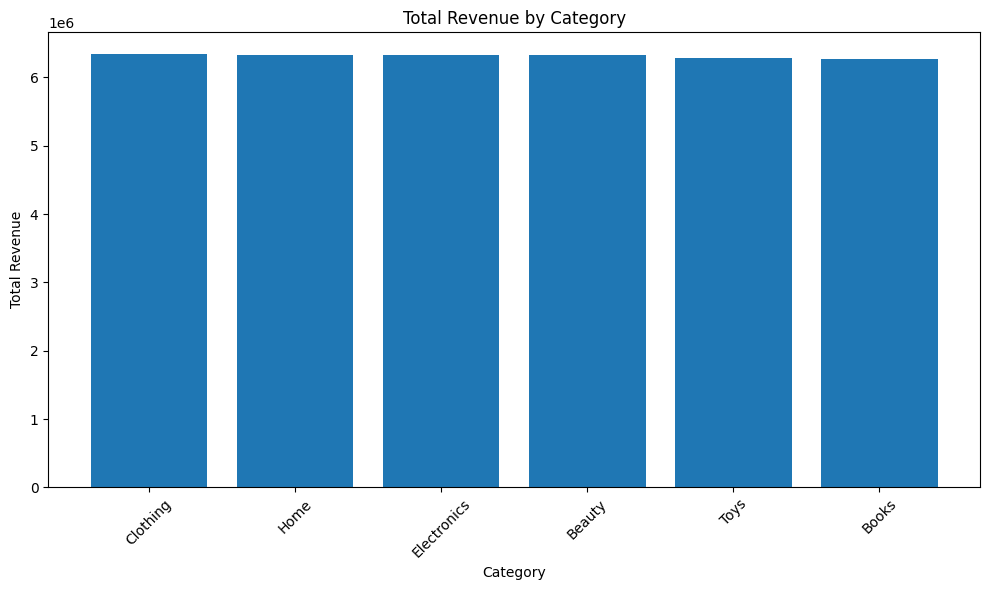

In [0]:
# Total revenue per category
category_sales = retail_data_cleaned.groupBy("category") \
    .agg(F.round(F.sum("final_price"), 2).alias("total_revenue")) \
    .orderBy("total_revenue", ascending=False)

# Show table
display(category_sales)

pandas_df = category_sales.toPandas()
plt.figure(figsize=(10,6))
plt.bar(pandas_df["category"], pandas_df["total_revenue"])
plt.title("Total Revenue by Category")
plt.xlabel("Category")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Business Question: How has revenue evolved over time (monthly)?

In [0]:
# Sales Trend Over Time (Line Chart). 
monthly_sales = retail_data_cleaned.withColumn("year_month", date_format("purchase_date", "yyyy-MM")) \
    .groupBy("year_month") \
    .agg(F.round(F.sum("final_price"), 2).alias("total_revenue")) \
    .orderBy("year_month")

display(monthly_sales)

year_month,total_revenue
2023-06,480340.54
2023-07,1600947.64
2023-08,1622559.62
2023-09,1524438.2
2023-10,1660197.75
2023-11,1539039.13
2023-12,1625710.26
2024-01,1602949.9
2024-02,1486739.63
2024-03,1609237.69


Business Question: Which products drive the most volume?

In [0]:
# Top 10 Most Frequently Purchased Products
top_products = retail_data_cleaned.groupBy("product_id") \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(10)

display(top_products)

product_id,count
5953b5d4-2e85-4607-af62-752490ac7063,1
9a3336ee-3938-4322-937e-95ed57eaefa6,1
6c99ce56-a58a-4bb5-9f19-30e0cda7a451,1
9d7c24ce-85d5-4ed9-8abd-bcd1782ccfec,1
4d2a5ec7-029d-44a0-8609-ac3b386b8594,1
75ef8169-64a7-4279-8609-a880ef29c0f7,1
2a23e15b-82b1-44bc-a8f0-178b61ffc40f,1
bf64f03d-e974-4e30-9525-b12e04bf1e72,1
ef46e612-6d5c-4842-a73e-153db6397107,1
7c928924-ff2c-4e6e-a130-73b9f45332b5,1


Business Question: Which payment methods are most popular among users?

In [0]:
# Preferred Payment Method (Pie or Bar Chart)
payment_method_dist = retail_data_cleaned.groupBy("payment_method") \
    .count() \
    .orderBy("count", ascending=False)

display(payment_method_dist)

payment_method,count
Card,25161
COD,25103
Wallet,24925
UPI,24811


Business Question: Which product categories generate the most revenue?


In [0]:
# Revenue by Product Category
category_revenue = retail_data_cleaned.groupBy("category") \
    .agg(
        F.count("*").alias("transactions"),
        F.round(F.sum("final_price"), 2).alias("total_revenue")
    ) \
    .orderBy("total_revenue", ascending=False)

display(category_revenue)

category,transactions,total_revenue
Clothing,16632,6342671.95
Home,16743,6332215.78
Electronics,16698,6326943.59
Beauty,16661,6321260.49
Toys,16624,6285589.32
Books,16642,6275382.62


Business Question: When are people most likely to shop — which day and time?

In [0]:
# Revenue Heatmap by Day of Week and Hour (Advanced Insight)
heatmap_df = retail_data_cleaned.withColumn("day_of_week", dayofweek("purchase_date")) \
    .withColumn("hour", hour("purchase_date")) \
    .groupBy("day_of_week", "hour") \
    .agg(F.round(F.sum("final_price"), 2).alias("total_revenue")) \
    .orderBy("day_of_week", "hour")

display(heatmap_df)

day_of_week,hour,total_revenue
1,0,5421867.43
2,0,5346844.57
3,0,5334581.9
4,0,5418737.08
5,0,5462972.41
6,0,5483650.41
7,0,5415409.95


 Note: day_of_week returns values 1 (Sunday) to 7 (Saturday).

## Summary of Key Insights
- Revenue Performance: Credit Card was the most frequently used payment method, followed by UPI and then Wallet, indicating a strong consumer preference for digital and cashless payments.
- Category Trends: The Home and Electronics categories dominated the sales volume, indicating strong consumer demand in these segments.
However, Clothing generated the most revenue despite fewer transactions.
- Revenue by Day of the Week: Analysis revealed that Fridays and Saturdays generated the highest total revenue compared to other days of the week. This trend likely reflects increased consumer spending behavior toward the weekend, which is common in retail patterns.
- Cash on Delivery (COD) Performance: Cash on Delivery was the second most-used payment method by transaction volume and revenue, yet it had the highest average order value. This suggests that COD customers tend to make higher-value purchases, indicating strong consumer trust in the option. Maintaining COD may be critical for retaining high-spending customers and supporting overall revenue growth.

## Business Recommendations
#### Boost Promotional Efforts Toward Weekends
- Insight: Fridays and Saturdays recorded the highest total revenue.
- Recommendation: Launch key promotional campaigns and flash sales on Fridays and Saturdays to leverage higher customer purchase intent toward the weekend. Consider scheduling product drops, marketing emails, or limited-time offers around these peak revenue days.

#### Optimize for Cash on Delivery (COD) Customers
- Insight: COD had the second-highest total transactions, second-highest revenue, and the highest average order value.
- Recommendation: Although digital payments are rising, the strong performance of COD suggests trust or accessibility factors. Improve logistics and checkout experience for COD users to retain and convert high-value customers. Also, offer loyalty rewards or upsells targeted to this group.

### Explore Product Category Dynamics Further
- Insight: Some product categories consistently performed better in sales and volume.
- Recommendation: Perform deep dives into individual product categories. Prioritize inventory planning, ad spend, and bundling offers around top-performing categories, especially those with both high purchase counts and average order values.